# Intro to Spatial Data

In this section, we will explore various spatial data formats, operations, and visualization methods. As before, there is large landscape of tools and platforms designed to work for spatial data. We will be focusing on a subset of tools now emerging at the leading edge of cloud-native geospatial computing. 

Geospatial computation can be divided into three components:

- Data I/O (input/output)
- Data manipulation / analysis
- Data visualization

## Data I/O

We divide geospatial data[^1] into two broad classes of data:

- raster data
- vector data

**Raster** data, also called "image" data or gridded data are made up of pixels.  **Vector** data is made out of spatial coordinates expressing shapes as points, lines, or polygons. 


[^1]: The same concepts exist in computer graphics, e.g. png vs svg.  Unlike computer graphics formats which typically represent images in a 'flat' (Euclidian) geometry, geospatial data must contend with the curvature of the earth using an explicit notion of coordinate reference systems.  We will have more to say about this later.


In [1]:
import ibis
from ibis import _

con = ibis.duckdb.connect()

### Working with Vector data

As with tabular data, our first task is to _read_ our data object from a file into python. Spatial vector data can be found in a bewildering array of formats or file types (or "serializations"). Because some common platforms can only understand a few of these formats, it is not uncommon to see spatial data providers offer the same data in multile formats. Fortunately for us can more-or-less all be read in the same way.  


Just as `pandas` has historically been the go-to for reading in tabular data, `geopandas` is the most common mechanism for reading spatial data into python.  Built on top of `pandas`, it faces the same limitations, especially when it comes to very big geospatial data.  Rather than teaching you different tools to work with 'small' and 'big' data, thanks to recent innovations we will be able to start off learning the faster, more scalable 'big data' solutions provided by `duckdb` and accessible to us in `ibis`.

Let's begin by looking at the redlining data from the Mapping Inequality Project, <https://dsl.richmond.edu/panorama/redlining/data>.  This data provider offers the ability to "download" the data in either format. `ibis` [^2] can read either one, and can do so both directly from the URL and without downloading the entire file.  Use a two-finger click on the download button to copy-paste the download URL into your notebook, like so:


[^2]: Good abstractions are at the core of good software design.  `ibis` isn't really doing the heavy lifting here, it is merely providing a user-friendly 'pythonic' interface to many different "backends" that perform the actual computation.  Only one of those, `duckdb`, is providing the spatial abilities we need.  When it comes to reading different file formats, `duckdb` achieves this only by calling out to another piece of software, `GDAL`, which has been around a lot longer and can be found under the hood of a great many geospatial data tools, from python packages like `geopandas` to QGIS to Google Earth Engine.

In [2]:
%%time
redlines = con.read_geo("/vsicurl/https://dsl.richmond.edu/panorama/redlining/static/mappinginequality.gpkg")

CPU times: user 542 ms, sys: 110 ms, total: 653 ms
Wall time: 1.67 s


Note how we have added the prefix `/vsicurl/` in the URL.  This signifies to the underlying software (GDAL) that we wish to use the virtual system interface to access this url, i.e. rather than first copying the file to the local machine, we access just the bytes we need over 'range requests'.  Previously we have seen `ibis` do this 'range request' trick automatically on URLs for text-based data, and in future this explicit prefix may not be necessary here either. 

In [3]:
#%%time
#without_vsi = con.read_geo("https://dsl.richmond.edu/panorama/redlining/static/mappinginequality.gpkg")

We can now use our `ibis` functions to explore this data.   What columns are in this data?

In [4]:
redlines.columns

['area_id',
 'city',
 'state',
 'city_survey',
 'category',
 'grade',
 'label',
 'residential',
 'commercial',
 'industrial',
 'fill',
 'geom']

Let's sample a few city names from the data:

In [5]:
redlines.select(_.city).distinct().head(10).execute() 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,city
0,Pittsburgh
1,Wilkes-Barre
2,Providence
3,Woonsocket
4,Greenville
5,Bristol
6,Spokane
7,Madison
8,Batesville
9,Oakland


or select all the data for a specific city:

In [6]:
city = redlines.filter(_.city == "New Haven")

As before, we can use the `.execute()` method to materialize our data into memory. Only instead of getting a `pandas` object, because it is spatial we get a `geopandas` object back.  

In [7]:
city_gdf = city.head().execute()
city_gdf

,area_id,city,state,city_survey,category,grade,label,residential,commercial,industrial,fill,geom
0,3569,New Haven,CT,True,Best,A,A1,True,False,False,#76a865,"MULTIPOLYGON (((-72.90000 41.36885, -72.90325 ..."
1,3568,New Haven,CT,True,Best,A,A2,True,False,False,#76a865,"MULTIPOLYGON (((-72.89401 41.36331, -72.89256 ..."
2,3566,New Haven,CT,True,Best,A,A3,True,False,False,#76a865,"MULTIPOLYGON (((-72.90981 41.35949, -72.90284 ..."
3,3567,New Haven,CT,True,Best,A,A4,True,False,False,#76a865,"MULTIPOLYGON (((-72.90284 41.35795, -72.89990 ..."
4,3564,New Haven,CT,True,Best,A,A5,True,False,False,#76a865,"MULTIPOLYGON (((-72.89801 41.34930, -72.89883 ..."


## Geometries and WKT

At first glance this looks like a familar `pandas` table.  But the last column, `geom` looks a little different, with content like `MULTIPOLYGON (((-72.9 41.36885, -72.90325 41.3...`.  These text strings follow a specific standardized format for representing shapes called "[Well Known Text](https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry)".  These shapes (points, lines, polygons, as well as disjoint versions such as multipoint, multiline, and multipolygon), are collectively refered to as "features".  

fun fact: if asked for a single feature, geopandas will actually draw it:

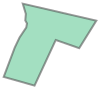

In [17]:
city_gdf.geom[3]

We can coerce WKT into a plain string of text, and see that is simply an ordered list of X Y pairs of points like a connect-the-dots puzzle (in this case, in Longitude-Latitude pairs):

In [18]:
str(city_gdf.geom[3])

'MULTIPOLYGON (((-72.90284 41.35795, -72.8999 41.35712, -72.89788 41.36147, -72.89564 41.36069, -72.89401 41.36331, -72.90102 41.36493, -72.90073 41.36396, -72.90078 41.36333, -72.90062 41.36305, -72.90069 41.36266, -72.90132 41.36172, -72.90178 41.36076, -72.90284 41.35795)))'

## Spatial operations

In addition to the standard operations `ibis` can perform on tabular data, the spatial extension provides an extensive collection of operations specific to spatial geometries. The `ibis` documentation provides a table of all [available methods](https://ibis-project.org/reference/expression-geospatial#methods).[^3]  For instance, a common task is to compute the area inside each polygon. 


[^3]: some additional methods are possible in the underlying [duckdb spatial extension](https://duckdb.org/docs/extensions/spatial/overview.html) but do not yet have bindings in `ibis`.  `ibis` provides an extension syntax that allows users to invoke these methods.  

In [8]:
city = (redlines
        .filter(_.city == "New Haven")
        .mutate(area = _.geom.area())
       )

## References

- [Introduction to GIS Programming by Qiusheng Wu](https://geog-312.gishub.org/index.html)